# Scalable Vector Data Analysis

You can access this notebook (in a Docker image) on this [GitHub repo](https://github.com/HamedAlemo/vector-data-tutorial).

In this lecture, we are going to use `Dask-GeoPandas` package to read a large vector dataset from [Source Cooperative](https://source.coop). Then use Dask parrallel computation to apply a spatial join operation to two geospatial DataFrames. 

Our target dataset is the `Google-Microsoft Open Buildings - combined by VIDA` dataset hosted on [Source Cooperative](https://source.coop/repositories/vida/google-microsoft-open-buildings/description). This is a combined version of the [Google](https://sites.research.google/open-buildings/) and [Microsoft](https://planetarycomputer.microsoft.com/dataset/ms-buildings) Open Buildings datasets and it has files in GeoParquet format hosted on AWS S3 bucket. Read the dataset description to familiarize yourself with the dataset and its structure. 

GeoParquet is a relatively new and open data format for column-oriented geospatial data. This format is build on the existing Apache Parquet format which is a very powerful format replacing CSV. You can check the specification [here](https://geoparquet.org/), and read more about the format on [this website](https://geoparquet.org/). In short, this format is interoperable, compressed and designed to work with large scale datasets. 

## Source Cooperative

Source Cooperative is a neutral, non-profit data-sharing utility that allows trusted organizations to share data without purchasing a data portal SaaS subscription or managing infrastructure. Source Cooperative is managed by Radiant Earth, and hosts 10s of datasets on its repository. 

In order to access/download data, you need to create a free account on Source Cooperative. Click on Sign in/up at the top of the page [here](https://source.coop/), and follow the steps to create an account. Make sure to use a non-Clark email to keep your account active after your graduation. 

### AWS Set up

All data on Source Cooperative, are hosted on AWS S3 bucket. In order to access them, you need  credentials that you can generate on Source Cooperative website. Atfer logging in, click on your name at the top right corner, and then click on your username. Then navigate to "Manage" page on the left side. At the bottom of this page you will find a section called "API Keys". If no key has been generated before, generate a new one and then copy the values for each of the following keys, and paste them in the following cell: 

In [1]:
AWS_ACCESS_KEY_ID = "SCDQA6KAMBGFNG98KK5J1AYN"
AWS_SECRET_ACCESS_KEY = "lmqqCa2vtk4Ac3SzgyruPBKjSs0IGZGNZzqDbaLsbMheET7LMP6kN5fWNwsAeQ6X"

Next, you need to create a s3 client from `boto3` library using your Source Cooperative credentials:

In [2]:
import boto3
s3_client = boto3.client('s3',
                         aws_access_key_id = AWS_ACCESS_KEY_ID, 
                         aws_secret_access_key = AWS_SECRET_ACCESS_KEY,
                         endpoint_url='https://data.source.coop'
                        )

## Download and Load Buildings Footprint Data into Dask-GeoPandas

First, we start a new Dask cluster:

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


2024-11-17 01:07:57,786 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 76f1ae92f3654bb2df8ba7e1257b2500 initialized by task ('shuffle-transfer-76f1ae92f3654bb2df8ba7e1257b2500', 4) executed on worker tcp://127.0.0.1:35725
2024-11-17 01:08:08,525 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 76f1ae92f3654bb2df8ba7e1257b2500 deactivated due to stimulus 'task-finished-1731805688.5253875'


In this lecture, we are going to access the data from a specific country. As noted in the dataset description, you need the 3-letter country ISO name to access the corresponding file. You can look up the ISO name for your country of choice [here](https://www.iso.org/obp/ui/#search).

You need to enter the ISO name and the EPSG corresponding to the UTM zone of your country of choice in the following:

In [4]:
#Rwanda
country_code = "RWA"
country_epsg = 32736

Define a path to download the data:

In [5]:
local_path = "./data/"

Let's import our function from `utils` module and run it. This function uses Dask-GeoPandas to lazy load the data from GeoParquet format into memory. 

In [6]:
from utils import get_google_microsoft_bldgs

The following cell downloads the geoparquet file from s3 bucket, and loads it into `Dask-GeoPandas` `GeoDataFrame`. We are using a default value of 256M for the blocksize in Dask. If you run into memory issue in the rest of the notebook, lower the blocksize and re-run the following cell. 

In [7]:
bldg_ddf = get_google_microsoft_bldgs(country_code, s3_client, local_path, blocksize = "256M")

File already exists locally. No download needed.


In [8]:
bldg_ddf

Dask GeoDataFrame Structure:
              boundary_id bf_source confidence area_in_meters  s2_id country_iso geohash  geometry    bbox
npartitions=5                                                                                             
                    int64    object    float64        float64  int64      object  object  geometry  object
                      ...       ...        ...            ...    ...         ...     ...       ...     ...
...                   ...       ...        ...            ...    ...         ...     ...       ...     ...
                      ...       ...        ...            ...    ...         ...     ...       ...     ...
                      ...       ...        ...            ...    ...         ...     ...       ...     ...
Dask Name: read_parquet, 1 expression
Expr=FromGraph(af3c061)

## Read Adminsitrative Boundaries Dataset

We are also interested to load the adminsitrative boundaries dataset for our country of choice, and assign each building an administrative unit (Parish) name. 

You can download each countries administrative unit json files on GDAM [website](https://gadm.org/download_country.html). Each country has different number of levels for their administrative units (and not all are available on GDAM website). 

Check your country of choice, and find what is the highest level of administrative boundaries that is available. 

In the following, we are interested in level 4 data, and the following function will download it. 

In [9]:
from utils import get_gdam_json

In [13]:
boundaries = get_gdam_json(country_code = country_code, admin_level=4)

In [14]:
boundaries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
boundaries.head()

GID_4 GID_0 COUNTRY    GID_1        NAME_1      GID_2  NAME_2  \
0  RWA.1.1.1.1_1   RWA  Rwanda  RWA.1_1  Amajyaruguru  RWA.1.1_1  Burera   
1  RWA.1.1.1.2_1   RWA  Rwanda  RWA.1_1  Amajyaruguru  RWA.1.1_1  Burera   
2  RWA.1.1.1.3_1   RWA  Rwanda  RWA.1_1  Amajyaruguru  RWA.1.1_1  Burera   
3  RWA.1.1.1.4_1   RWA  Rwanda  RWA.1_1  Amajyaruguru  RWA.1.1_1  Burera   
4  RWA.1.1.2.1_1   RWA  Rwanda  RWA.1_1  Amajyaruguru  RWA.1.1_1  Burera   

         GID_3  NAME_3    Parish VARNAME_4 TYPE_4 ENGTYPE_4    CC_4  \
0  RWA.1.1.1_1  Bungwe    Bungwe        NA   Cell      Cell  440101   
1  RWA.1.1.1_1  Bungwe  Bushenya        NA   Cell      Cell  440102   
2  RWA.1.1.1_1  Bungwe  Mudugari        NA   Cell      Cell  440103   
3  RWA.1.1.1_1  Bungwe     Tumba        NA   Cell      Cell  440104   
4  RWA.1.1.2_1  Butaro   Gatsibo        NA   Cell      Cell  440201   

                                            geometry  
0  MULTIPOLYGON (((29.9763 -1.5148, 29.9733 -1.51...  
1  MULTIPOLYGON (((29.9673 -1.4826, 29.9616 -1.48...  
2  MULTIPOLYGON (((29.961 -1.4714, 29.9629 -1.473...  
3  MULTIPOLYGON (((29.9713 -1.5133, 29.9811 -1.51...  
4  MULTIPOLYGON (((29.8394 -1.3918, 29.8387 -1.39...

## Spatial Join

Now, we will use the spatial join to add the Parish name (`Parish` column in `boundaries`) to `bldg_ddf`:

In [16]:
bldg_ddf_w_boundaries = bldg_ddf.sjoin(boundaries, how="inner", predicate="intersects")

In [17]:
bldg_ddf_w_boundaries

Dask GeoDataFrame Structure:
              boundary_id bf_source confidence area_in_meters  s2_id country_iso geohash  geometry    bbox index_right   GID_4   GID_0 COUNTRY   GID_1  NAME_1   GID_2  NAME_2   GID_3  NAME_3  Parish VARNAME_4  TYPE_4 ENGTYPE_4    CC_4
npartitions=5                                                                                                                                                                                                                             
                    int64    object    float64        float64  int64      object  object  geometry  object       int64  string  string  string  string  string  string  string  string  string  string    string  string    string  string
                      ...       ...        ...            ...    ...         ...     ...       ...     ...         ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...       ...     ...       ...     ...
...                   ...       ...        ...            ...    ...         ...     ...       ...     ...         ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...       ...     ...       ...     ...
                      ...       ...        ...            ...    ...         ...     ...       ...     ...         ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...       ...     ...       ...     ...
                      ...       ...        ...            ...    ...         ...     ...       ...     ...         ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...       ...     ...       ...     ...
Dask Name: sjoin, 1 expression
Expr=FromGraph(cdc5550)

In [18]:
buildigs_per_parish = bldg_ddf_w_boundaries["Parish"].value_counts().compute()

In [19]:
buildigs_per_parish

Parish
Agakomeye      3832
Agateko        5431
Akinyambo      6058
Banda          1885
Barari         2241
               ... 
Twiya          1112
Ubumwe          577
Umukamba       2197
Uwacyiza       1731
Uwumusebeya    2344
Name: count, Length: 1483, dtype: int64[pyarrow]

In [20]:
print(f"Total number of buildings is {buildigs_per_parish.sum()}")

Total number of buildings is 6326876


### Exercise 1: Plot the number of buildings per Parish on the map

In [21]:
boundaries_w_count = boundaries.merge(buildigs_per_parish, on="Parish")

In [22]:
boundaries_w_count

GID_4 GID_0 COUNTRY    GID_1          NAME_1      GID_2  \
0      RWA.1.1.1.1_1   RWA  Rwanda  RWA.1_1    Amajyaruguru  RWA.1.1_1   
1      RWA.1.1.1.2_1   RWA  Rwanda  RWA.1_1    Amajyaruguru  RWA.1.1_1   
2      RWA.1.1.1.3_1   RWA  Rwanda  RWA.1_1    Amajyaruguru  RWA.1.1_1   
3      RWA.1.1.1.4_1   RWA  Rwanda  RWA.1_1    Amajyaruguru  RWA.1.1_1   
4      RWA.1.1.2.1_1   RWA  Rwanda  RWA.1_1    Amajyaruguru  RWA.1.1_1   
...              ...   ...     ...      ...             ...        ...   
2164   RWA.5.3.9.4_1   RWA  Rwanda  RWA.5_1  UmujyiwaKigali  RWA.5.3_1   
2165  RWA.5.3.10.2_1   RWA  Rwanda  RWA.5_1  UmujyiwaKigali  RWA.5.3_1   
2166  RWA.5.3.10.1_1   RWA  Rwanda  RWA.5_1  UmujyiwaKigali  RWA.5.3_1   
2167  RWA.5.3.10.3_1   RWA  Rwanda  RWA.5_1  UmujyiwaKigali  RWA.5.3_1   
2168  RWA.5.3.10.4_1   RWA  Rwanda  RWA.5_1  UmujyiwaKigali  RWA.5.3_1   

          NAME_2         GID_3      NAME_3        Parish VARNAME_4 TYPE_4  \
0         Burera   RWA.1.1.1_1      Bungwe        Bungwe        NA   Cell   
1         Burera   RWA.1.1.1_1      Bungwe      Bushenya        NA   Cell   
2         Burera   RWA.1.1.1_1      Bungwe      Mudugari        NA   Cell   
3         Burera   RWA.1.1.1_1      Bungwe         Tumba        NA   Cell   
4         Burera   RWA.1.1.2_1      Butaro       Gatsibo        NA   Cell   
...          ...           ...         ...           ...       ...    ...   
2164  Nyarugenge   RWA.5.3.9_1  Nyarugenge      Rwampara        NA   Cell   
2165  Nyarugenge  RWA.5.3.10_1  Rwezamenyo     KabuguruI        NA   Cell   
2166  Nyarugenge  RWA.5.3.10_1  Rwezamenyo    KabuguruIi        NA   Cell   
2167  Nyarugenge  RWA.5.3.10_1  Rwezamenyo   RwezamenyoI        NA   Cell   
2168  Nyarugenge  RWA.5.3.10_1  Rwezamenyo  RwezamenyoIi        NA   Cell   

     ENGTYPE_4    CC_4                                           geometry  \
0         Cell  440101  MULTIPOLYGON (((29.9763 -1.5148, 29.9733 -1.51...   
1         Cell  440102  MULTIPOLYGON (((29.9673 -1.4826, 29.9616 -1.48...   
2         Cell  440103  MULTIPOLYGON (((29.961 -1.4714, 29.9629 -1.473...   
3         Cell  440104  MULTIPOLYGON (((29.9713 -1.5133, 29.9811 -1.51...   
4         Cell  440201  MULTIPOLYGON (((29.8394 -1.3918, 29.8387 -1.39...   
...        ...     ...                                                ...   
2164      Cell  110904  MULTIPOLYGON (((30.0618 -1.9723, 30.0571 -1.97...   
2165      Cell  111001  MULTIPOLYGON (((30.0531 -1.971, 30.0523 -1.971...   
2166      Cell  111002  MULTIPOLYGON (((30.0472 -1.9744, 30.0491 -1.97...   
2167      Cell  111003  MULTIPOLYGON (((30.0563 -1.9715, 30.0548 -1.97...   
2168      Cell  111004  MULTIPOLYGON (((30.0475 -1.9781, 30.0468 -1.97...   

      count  
0      5151  
1      1708  
2      1200  
3      3432  
4      8984  
...     ...  
2164   3968  
2165   1406  
2166   1061  
2167   2155  
2168    959  

[2169 rows x 16 columns]

<Axes: >

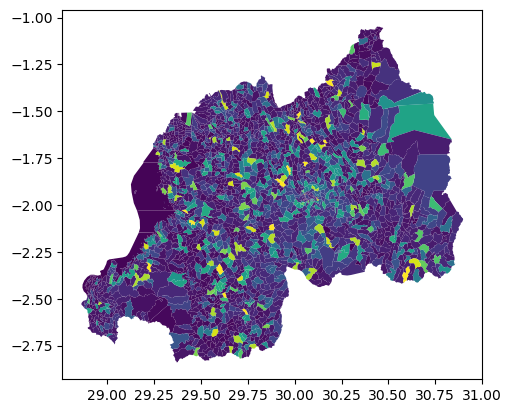

In [23]:
boundaries_w_count.plot("count")

In [24]:
boundaries_w_count.explore("count")

### Exercise 2: Calculate percentage of the area of each Parish that is covered by buildings

In [25]:
bldg_area_per_parish = bldg_ddf_w_boundaries.groupby("Parish")["area_in_meters"].sum().compute()

In [26]:
boundaries_w_count = boundaries_w_count.merge(bldg_area_per_parish, on="Parish")

In [27]:
boundaries_w_count.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

To calculate the correct area of each Parish we need to project the geometries to a CRS that has units of meter. Here we will use `country_epsg` to reproject the data.

In [28]:
boundaries_w_count["percent_bldg"] = boundaries_w_count["area_in_meters"] / boundaries_w_count.to_crs(country_epsg).area * 100

In [29]:
boundaries_w_count.explore("percent_bldg", vmax = 15)